In [21]:
%matplotlib inline

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from tabulate import tabulate

In [23]:
%%time
code_list = ['W993008','W993009','W993010','W993023']
data = []
for code in code_list:
    tmp = pd.read_csv('../data/csv_day/%s.csv'%code, index_col=False).sort_values(by=['Date'],ascending=True).reset_index(drop=True)
    tmp.index = pd.to_datetime(tmp['Date'])
    tmp = tmp.drop(['Date'], axis=1)
    #tmp['code'] = code
    data.append(tmp)

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 46.5 ms


In [24]:
data = pd.concat(data, keys=code_list)
data.loc[code_list] = np.array(list(map(lambda x:float(str(x[0]).replace(',','')), data.loc[code_list].values))).reshape(-1,1)

In [25]:
cur_date = data.loc[code_list[0]].index[120]
prev_date = data.loc[code_list[0]].index[0]

In [26]:
print(data.loc[(code_list,cur_date),:])
print(data.loc[(code_list,prev_date),:])

                      Index
        Date               
W993008 2001-12-07  1142.80
W993009 2001-12-07  1171.36
W993010 2001-12-07  1087.73
W993023 2001-12-07  1153.74
                     Index
        Date              
W993008 2001-06-15  1000.0
W993009 2001-06-15  1000.0
W993010 2001-06-15  1000.0
W993023 2001-06-15  1000.0


In [27]:
def plot_result(res):
    # plot result
    res = pd.DataFrame(res, columns=["Date", "balance"])
    fig, ax = plt.subplots()
    ax.plot(res["Date"], res["balance"])

    import matplotlib.dates as mdates
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%02Y')

    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)

    # round to nearest years...
    datemin = np.datetime64(res.iloc[0,0], 'Y')
    datemax = np.datetime64(res.iloc[-1,0], 'Y') + np.timedelta64(1, 'Y')
    ax.set_xlim(datemin, datemax)
    ax.set_yscale("log")

    fig.autofmt_xdate()
    plt.show()

In [28]:
nlen = len(data.loc[code_list[0]])
balance_list = []
profit_list = []
best_balance = prev_balance = balance = 1e4
year_balance = [balance]
mdd = 1
prev_year = 2016
for i in range(0,nlen):
    if i < 21*6 or nlen < i+21:
        continue
    cur_date = data.loc[code_list[0]].index[i]
    past_6m_date = data.loc[code_list[0]].index[i-21*6]
    yesterday = data.loc[code_list[0]].index[i-1]
    
    # 월 1회 리밸런싱
    if i%21 == 0:
        # 최근 6개월간 가장 많이 오른 지수에 투자
        div = np.divide(data.loc[(code_list,cur_date),'Index'], data.loc[(code_list,past_6m_date),'Index']).values
        top = np.argmax(div)
        # 네 개 지수의 6개월 수익이 예금금리 이하로 감소하면 모든 ETF 매도 후 현금 보유
        if data.loc[(code_list[top],cur_date),'Index']/data.loc[(code_list[top],past_6m_date),'Index'] < 0.015:
            top = -1
    
    if top >= 0:
        amt = balance/data.loc[(code_list[top],yesterday),'Index']
        balance += (data.loc[(code_list[top],cur_date),'Index']-data.loc[(code_list[top],yesterday),'Index'])*amt
    
    if cur_date.year != prev_year:
        year_balance.append(balance)
        prev_year = cur_date.year
    profit_list.append(balance/prev_balance-1)
    balance_list.append([cur_date, balance])
    prev_balance = balance
    best_balance = max(best_balance, balance)
    mdd = min(mdd, balance/best_balance)

  초기자산    최종자산  Return      CAGR(%)    표준편차(%)    최고의해    최악의해    MDD    샤프지수
----------  ----------  --------  ---------  -------------  ----------  ----------  -----  ----------
     10000     92477.9  x9          12.2595        0.26381       76.15      -32.78     53        0.76


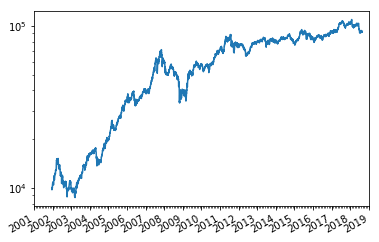

In [31]:
CAGR = (int(balance/1e4)**(1/len(year_balance))-1)*100
MDD = int((1-mdd)*100)
year_profit = np.divide(year_balance[1:],year_balance[:-1])
best_profit = max(year_profit)*100-100
worst_profit = min(year_profit)*100-100
best_profit = int(best_profit*100)/100
worst_profit = int(worst_profit*100)/100
SR = np.mean(profit_list)/np.std(profit_list)*np.sqrt(252)
SR = int(100*SR)/100
returns = 'x'+str(int(balance/1e4))
headers = ['초기자산', '최종자산', 'Return', 'CAGR(%)', '표준편차(%)', '최고의해', '최악의해', 'MDD', '샤프지수']
results = [1e4, balance, returns, CAGR, np.std(year_profit), best_profit, worst_profit, MDD, SR]
print(tabulate([results], headers=headers))
plot_result(balance_list)